In [28]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import json
import cPickle as pk
import os
import numpy as np
import pandas as pd
from time import time
import cv2
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
def load_everything():
    # load configuration
    with open('../config.json', 'rb') as f:
        config = json.load(f)

    mainImPath = config['image_dir']
    pDir = config['pickle_dir']

    bb = pk.load(open(pDir + 'pDogs-bounding-boxes-clean.pd.pk', 'rb'))
    bb.dropna(inplace=True)
    bb.path = bb.path.apply(lambda x: re.sub('scrape-ims', 'scrape_ims', x))

    breeds = list(sorted(bb.breed.unique().tolist()))

    return breeds, bb, mainImPath

def create_model(output_layer='block4_pool'):
    base_model = VGG19(weights='imagenet')
    model = Model(input=base_model.input, output=base_model.get_layer(output_layer).output)
    return model

def extract_feats(img_path):
        try:
            img = image.load_img(img_path, target_size=(224, 224))
        except IOError:
            print 'couldn\'t load file'
            return None

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        block4_pool_features = model.predict(x)
        return block4_pool_features

def extract_all_feats(timing=True):
    all_feats = None
    for b in breeds:
        print 'on breed:', b
        imDir = mainImPath + breeds[0] + '/'
        ims = os.listdir(imDir)
        for im in ims:
            start = time()
            print 'on image:', im
            b4 = extract_feats(imDir + im)
            if b4 is None:
                continue

            if all_feats is None:
                files = [im]
                all_feats = b4
            else:
                files.append(im)
                all_feats = np.c_[all_feats, all_feats]

            if timing:
                print 'took', time() - start, 'seconds'

    return files, all_feats

def test(output_layer='block4_pool', timing=True):
    start = time()
    testImDir = mainImPath + breeds[0] + '/'
    testIms = os.listdir(testImDir)
    print 'extracting features for', breeds[0]
    print 'file:', testIms[0]
    b4 = extract_feats(testImDir + testIms[0])
    if timing:
        runtime = time() - start
        print 'took', runtime, 'seconds'

    return b4, runtime, testImDir + testIms[0]

In [3]:
breeds, bb, mainImPath = load_everything()

In [4]:
base_model = VGG19(weights='imagenet')

# Here's the layers we can use as intermediate outputs:

In [5]:
for i in base_model.get_config()['layers']:
    print i['name']

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


In [6]:
base_model.get_config()['layers'][0]

{'class_name': 'InputLayer',
 'config': {'batch_input_shape': (None, 3, 224, 224),
  'input_dtype': 'float32',
  'name': 'input_1',
  'sparse': False},
 'inbound_nodes': [],
 'name': 'input_1'}

In [7]:
model = create_model() # creates VGG19 model with block4_pool_features out

In [8]:
testFeat, runtime, filename = test()

extracting features for Affenpinscher
file: Affenpinscher3-2.jpeg
took 6.46466302872 seconds


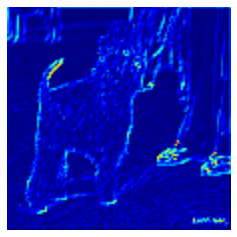

In [32]:
f = plt.imshow(testFeat[0][0])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
p = ax.axis('off')

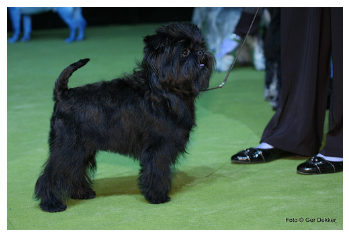

In [33]:
im = cv2.imread(filename)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
f = plt.imshow(im)

extracting features for Affenpinscher
file: Affenpinscher3-2.jpeg
took 0.969126939774 seconds


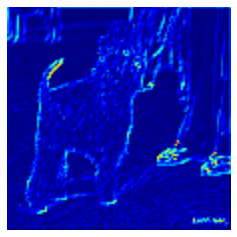

In [42]:
model = create_model(output_layer='block1_pool')
testFeat, runtime, filename = test()
f = plt.imshow(testFeat[0][0])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
p = ax.axis('off')

In [43]:
testFeat[0].shape

(64, 112, 112)

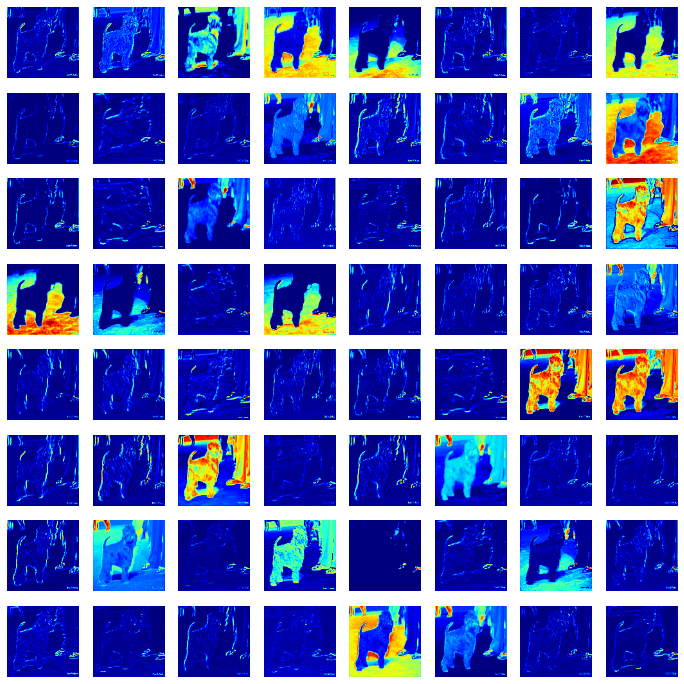

In [44]:
c = plt.figure(figsize=(12, 12))
for i in range (512):
    ax = c.add_subplot(8, 8, i + 1)
    ax.imshow(testFeat[0][i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    if i == 63:
        break

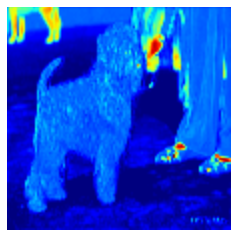

In [45]:
f = plt.imshow(testFeat[0][11])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
p = ax.axis('off')

extracting features for Affenpinscher
file: Affenpinscher3-2.jpeg
took 1.88415908813 seconds


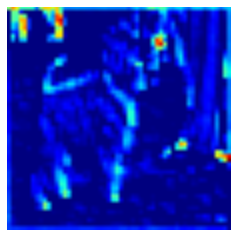

In [46]:
model = create_model(output_layer='block2_pool') # creates VGG19 model with block4_pool_features out
testFeat, runtime, filename = test()
f = plt.imshow(testFeat[0][0])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
p = ax.axis('off')

extracting features for Affenpinscher
file: Affenpinscher3-2.jpeg
took 4.16203713417 seconds


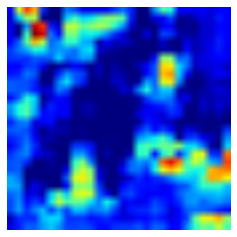

In [47]:
model = create_model(output_layer='block3_pool') # creates VGG19 model with block4_pool_features out
testFeat, runtime, filename = test()
f = plt.imshow(testFeat[0][0])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
p = ax.axis('off')

extracting features for Affenpinscher
file: Affenpinscher3-2.jpeg
took 5.71288204193 seconds


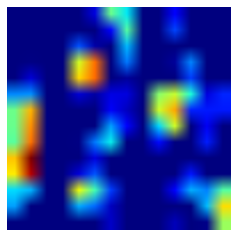

In [48]:
model = create_model(output_layer='block4_pool') # creates VGG19 model with block4_pool_features out
testFeat, runtime, filename = test()
f = plt.imshow(testFeat[0][0])
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
p = ax.axis('off')

In [49]:
testFeat.shape

(1, 512, 14, 14)

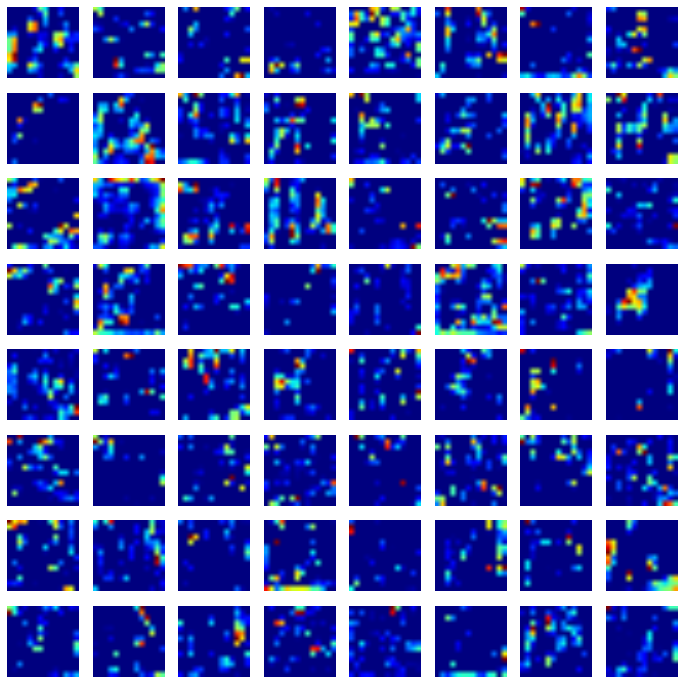

In [50]:
c = plt.figure(figsize=(12, 12))
for i in range (512):
    ax = c.add_subplot(8, 8, i + 1)
    ax.imshow(testFeat[0][i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    if i == 63:
        break

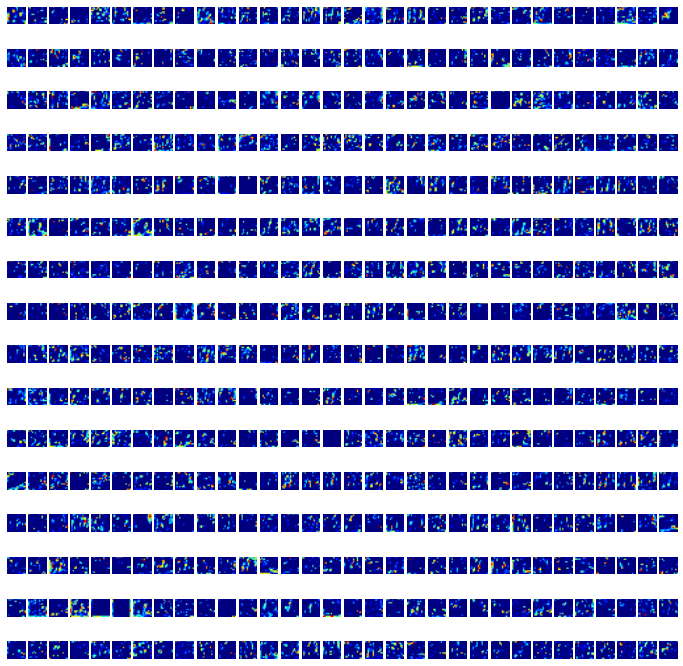

In [51]:
c = plt.figure(figsize=(12, 12))
for i in range (512):
    ax = c.add_subplot(16, 32, i + 1)
    ax.imshow(testFeat[0][i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')